In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
dataset = 'datasets/keypoint1000.csv'
model_save_path = 'models/keypoint_classifier.hdf5'
tflite_save_path = 'models/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 12

# Dataset reading

In [ ]:
def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 3) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dropout(0.3),  # Adjusted dropout rate
    tf.keras.layers.Dense(64, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dense(32, activation='relu'),  # Increased units
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 63)                0         
                                                                 
 dense (Dense)               (None, 128)               8192      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
es_callback

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000




71/71 [==============================] - ETA: 0s - loss: 2.5989 - accuracy: 0.1086
Epoch 1: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 3s 9ms/step - loss: 2.5989 - accuracy: 0.1086 - val_loss: 2.4621 - val_accuracy: 0.0870
Epoch 2/1000
59/71 [=======================>......] - ETA: 0s - loss: 2.4120 - accuracy: 0.1527

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 2.3989 - accuracy: 0.1569 - val_loss: 2.3929 - val_accuracy: 0.1613
Epoch 3/1000
57/71 [=======================>......] - ETA: 0s - loss: 2.3129 - accuracy: 0.1867
Epoch 3: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 2.3017 - accuracy: 0.1898 - val_loss: 2.2881 - val_accuracy: 0.2170
Epoch 4/1000
59/71 [=======================>......] - ETA: 0s - loss: 2.2193 - accuracy: 0.2263
Epoch 4: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 2.2106 - accuracy: 0.2254 - val_loss: 2.1277 - val_accuracy: 0.2910
Epoch 5/1000
59/71 [=======================>......] - ETA: 0s - loss: 2.1714 - accuracy: 0.2422
Epoch 5: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 2.1660 - accuracy: 0.2462 - val_los

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/24 [>.............................] - ETA: 0s - loss: 0.3715 - accuracy: 0.8594

24/24 [==============================] - 0s 2ms/step - loss: 0.3735 - accuracy: 0.8807


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 205ms/step
[2.5457076e-12 9.8817140e-01 6.5431799e-10 5.9180308e-13 3.5159544e-09
 6.6284970e-03 1.2950635e-10 4.8645926e-03 5.0591802e-07 5.4825126e-08
 3.2753387e-04 7.4961440e-06]
1


# Confusion matrix

94/94 [==============================] - 0s 1ms/step


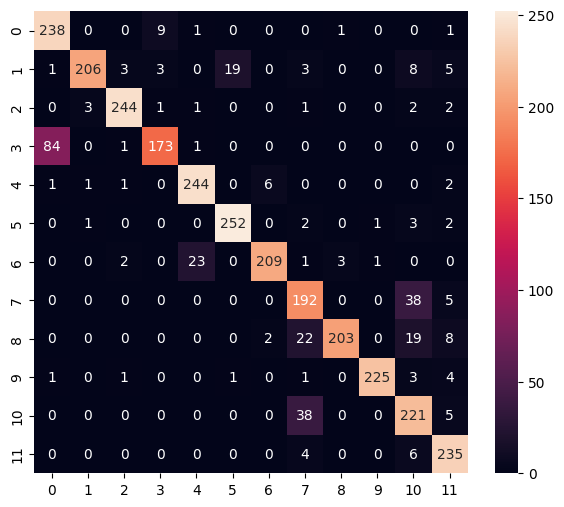

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.95      0.83       250
           1       0.98      0.83      0.90       248
           2       0.97      0.96      0.96       254
           3       0.93      0.67      0.78       259
           4       0.90      0.96      0.93       255
           5       0.93      0.97      0.95       261
           6       0.96      0.87      0.92       239
           7       0.73      0.82      0.77       235
           8       0.98      0.80      0.88       254
           9       0.99      0.95      0.97       236
          10       0.74      0.84      0.78       264
          11       0.87      0.96      0.91       245

    accuracy                           0.88      3000
   macro avg       0.89      0.88      0.88      3000
weighted avg       0.89      0.88      0.88      3000



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmpo1_p0twa\assets


INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmpo1_p0twa\assets


23992

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.34496309e-12 9.73744452e-01 1.32897554e-10 4.04224126e-13
 5.42117107e-09 1.10509722e-02 7.05611680e-11 1.43176615e-02
 4.04954017e-06 9.00648534e-09 8.49897042e-04 3.28952119e-05]
1
